In [335]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import itertools as it

In [336]:
def bytes_to_int_arr(byts):
    return [b for b in byts]


def pop_byte(byte_arr):
    return byte_arr.pop(0)


def pop_bytes(byte_arr, length):
    return bytes([pop_byte(byte_arr) for _ in range(length)])


def pop_uint8(byte_arr):
    return pop_byte(byte_arr)


def pop_uint32(byte_arr, byteorder='little'):
    byts = pop_bytes(byte_arr, 4)
    return int.from_bytes(byts, byteorder)
    
    
def pop_string(byte_arr, length, encoding='utf-8'):
    byts = pop_bytes(byte_arr, length)
    return byts.decode(encoding)
    
        
def indent(string):
    indent_str = ' ' * 3
    return indent_str + (('\n' + indent_str).join(string.splitlines()))

In [360]:
slice_footer = bytes([7, ] + ([0, ] * 31))
slice_footer_len = len(slice_footer)

class PhotoactivationMaskSlice:
    
    def __init__(self, header=None, footer=None, data=None):
        self.header = header
        self.data = data if data is None else bytes(data)
        self.footer = footer if footer is None else bytes(footer)

    def __repr__(self):
        repr_str = '''{:s}(
   header={},
   footer={},
   data={})'''.format(
            self.__class__.__name__,
            self.header,
            bytes_to_int_arr(self.footer),
            bytes_to_int_arr(self.data))
        return repr_str

    @staticmethod
    def build_from_bytes(byts):
        pam_slice = PhotoactivationMaskSlice()
        byts = bytearray(byts)
        header = tuple(pop_uint32(byts) for _ in range(2))
        data = pop_bytes(byts, len(byts) - slice_footer_len)
        footer = byts
        pam_slice = PhotoactivationMaskSlice(
            header=header,
            footer=footer,
            data=data)
        
        return pam_slice

        
class PhotoactivationMask:
    
    def __init__(self, name=None, shape=None, slices=None,):
        self.shape = shape
        self.slices = list() if slices is None else slices
        self.name = str() if name is None else name

    def __repr__(self):
        repr_str = '''{:s}(
   name=\'{:s}\',
   shape={},
   slices=[{:s}])'''.format(
            self.__class__.__name__,
            self.name, 
            self.shape, 
            '' if not self.slices else ('\n' + 
            indent(',\n'.join(indent(repr(sl)) for sl in self.slices))))
        return repr_str
        
    @staticmethod
    def build_from_binary(byts):
        byts = bytearray(byts)
        pam = PhotoactivationMask()
        
        name_length = pop_uint8(byts)
        pam.name = pop_string(byts, name_length)
        
        pam.shape = tuple(pop_uint32(byts) for _ in range(3))
        
        slice_byts = None
        
        while byts:
            if slice_byts is None:
                slice_byts = bytearray()
                slice_header = tuple(pop_uint32(byts) for _ in range(2))
                slice_byts += pop_bytes(byts, slice_header[0])
                
            elif byts[:slice_footer_len] == slice_footer:
                pop_bytes(byts, slice_footer_len)
                pam_slice = PhotoactivationMaskSlice(
                    header=slice_header,
                    footer=slice_footer,
                    data=slice_byts)
                pam.slices.append(pam_slice)
                
                slice_byts = None
                
            else:
                _next_len = int.from_bytes(byts[:4], 'little')
                slice_byts += pop_bytes(byts, _next_len + 4)
        
        assert len(pam.slices) == pam.shape[2]
        
        return pam
    
    @staticmethod
    def build_from_file(path):
        with open(path, 'rb') as fle:
            byts = fle.read()
        return PhotoactivationMask.build_from_binary(byts)

In [366]:
data_dir = 'data'
file_name = 'test_z_mask_04.pam'

file_path = os.path.join(data_dir, file_name)

pam = PhotoactivationMask.build_from_file(file_path)
# print(pam)

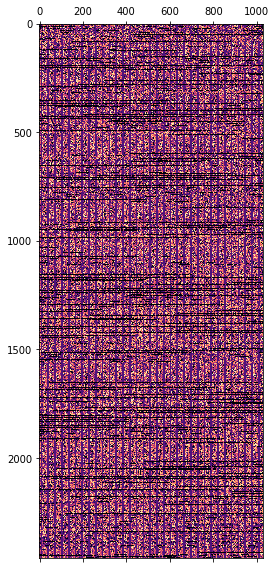

In [347]:
all_mask_data = bytes_to_int_arr(bytes().join(sl.data for sl in pam.slices))
mask_data_np = np.array(all_mask_data)
original_size = mask_data_np.size

vis_width = 1028
new_shape = (np.ceil(mask_data_np.size / vis_width).astype(int), vis_width)
mask_data_vis = np.resize(mask_data_np.astype(float), new_shape)

num_extra_values = mask_data_vis.size - original_size
extra_value_idxs = mask_data_vis.size - (np.arange(num_extra_values) + 1)
extra_value_slice = np.unravel_index(extra_value_idxs, mask_data_vis.shape)
mask_data_vis[extra_value_slice] = np.NaN

plt.matshow(mask_data_vis, cmap='magma')

In [357]:
_ = [print('header[0] = {:7d}, len(data) = {:7d}, len(data) - header[0] = {:7d}'.format(
        sl.header[0], 
        len(sl.data),
        len(sl.data) - sl.header[0]))
     for sl in pam.slices]

header[0] =      20, len(data) =      20, len(data) - header[0] =       0
header[0] =      20, len(data) =      20, len(data) - header[0] =       0
header[0] =   10120, len(data) =   17596, len(data) - header[0] =    7476
header[0] =   30520, len(data) =   45220, len(data) - header[0] =   14700
header[0] =   41560, len(data) =   97260, len(data) - header[0] =   55700
header[0] =   50296, len(data) =  149172, len(data) - header[0] =   98876
header[0] =   50816, len(data) =  157832, len(data) - header[0] =  107016
header[0] =  209388, len(data) =  319844, len(data) - header[0] =  110456
header[0] =  229088, len(data) =  757496, len(data) - header[0] =  528408
header[0] =  246380, len(data) =  986772, len(data) - header[0] =  740392


In [334]:
file_path_02 = os.path.join(data_dir, 'test_z_mask_02.pam')
file_path_04 = os.path.join(data_dir, 'test_z_mask_04.pam')

pam_2 = PhotoactivationMask.build_from_file(file_path_02)
pam_4 = PhotoactivationMask.build_from_file(file_path_04)

print_len = 100
print('pam_2, slice(2), len = {}, binary={}'.format(len(pam_2.slices[1].data),
                                                    bytes_to_int_arr(pam_2.slices[1].data[:print_len])))
print('pam_4, slice(3), len = {}, binary={}'.format(len(pam_4.slices[2].data),
                                                    bytes_to_int_arr(pam_4.slices[2].data[:print_len])))

pam_2, slice(2), len = 89048, binary=[37, 220, 225, 168, 1, 16, 192, 219, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 16, 108, 1, 0, 0, 1, 16, 192, 219, 39, 0, 0, 0, 0, 32, 0, 0, 133, 235, 49, 64, 0, 0, 128, 63, 133, 235, 49, 64, 127, 124, 218, 63, 63, 62, 13, 64, 133, 235, 17, 64, 0, 0, 192, 63, 133, 235, 17, 64, 0, 7, 75, 63, 133, 235, 17, 64, 176, 71, 97, 62, 127, 124, 218, 63, 176, 71, 97, 62, 0, 0, 128, 63, 176, 71, 97, 62]
pam_4, slice(3), len = 1080, binary=[243, 235, 216, 136, 1, 16, 192, 219, 8, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 16, 248, 0, 0, 0, 1, 16, 192, 219, 26, 0, 0, 0, 0, 32, 0, 0, 239, 71, 189, 63, 112, 175, 135, 61, 239, 71, 189, 63, 237, 238, 69, 63, 201, 218, 103, 63, 1, 82, 172, 63, 40, 135, 75, 62, 1, 82, 172, 63, 54, 23, 2, 191, 1, 82, 172, 63, 37, 102, 138, 191, 237, 238, 69, 63, 37, 102, 138, 191]
